In [68]:
# !pip install --upgrade pycaret
# !pip install cuml
# !pip install pycaret --upgrade

In [69]:
import pandas as pd
import numpy as np
from pycaret.regression import *

In [70]:
file = pd.ExcelFile("..\data\\food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx")
df = file.parse('CropStats')
df = df.set_index(df.columns[0])
df.index.name = None

## Clean Data
Columns with too many null values or meaningless information are dropped.  
Columns with unclear names are renamed.  
For the subnational column null values are filled up with corresponding values from the national column.  
For yield, production, and hectares, if one of them is null but the others in the same row are not, the null one can be calculated. Here we need to pay attention to not divide by 0.  
We chose to focus on wheat, so we will be filtering the df accordingly.  
We also added columns with logarithmic transformations for yield, production, and hectares.

In [71]:
df.drop(['admin2', 'notes', 'Harvest_year'], axis=1, inplace=True)
df.rename(columns = {'admin0': 'national', 'admin1': 'subnational', 'hectares (ha)': 'hectares_ha', 'production (tonnes)': 'production_tonnes', 'yield(tonnes/ha)': 'yield_tonnes_ha'}, inplace=True)
df.loc[df['subnational'].isna(), 'subnational'] = df['national']
# Calculate yield
mask = df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna() & ~df['hectares_ha'].isna() & df['hectares_ha'] != 0
df.loc[mask, 'yield_tonnes_ha'] = df['production_tonnes'] / df['hectares_ha']
df.dropna(subset=['yield_tonnes_ha'], inplace=True)
# Calculate production
mask = df['production_tonnes'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['hectares_ha'].isna()
df.loc[mask, 'production_tonnes'] = df['yield_tonnes_ha'] * df['hectares_ha']
df.dropna(subset=['production_tonnes'], inplace=True)
# Calculate hectares
mask = df['hectares_ha'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna()
df.loc[mask, 'hectares_ha'] = df['yield_tonnes_ha'] * df['production_tonnes']
df.dropna(subset=['hectares_ha'], inplace=True)
# The columns we just adapted just changed into objects, let's make them floats again
df['hectares_ha'] = df['hectares_ha'].astype(float)
df['production_tonnes'] = df['production_tonnes'].astype(float)
df['yield_tonnes_ha'] = df['yield_tonnes_ha'].astype(float)
# Filter for wheat
df = df[df['crop'] == 'wheat']
# Remove the crop column
df.drop('crop', axis=1, inplace =True)
# Logarithmic transformations
df['log_yield'] = np.log1p(df['yield_tonnes_ha'])
df['log_hectares'] = np.log1p(df['production_tonnes'])
df['log_production'] = np.log1p(df['hectares_ha'])


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15479 entries, 59 to 36706
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   national           15479 non-null  object 
 1   subnational        15479 non-null  object 
 2   hectares_ha        15479 non-null  float64
 3   production_tonnes  15479 non-null  float64
 4   year               15479 non-null  int64  
 5   yield_tonnes_ha    15479 non-null  float64
 6   log_yield          15479 non-null  float64
 7   log_hectares       15479 non-null  float64
 8   log_production     15479 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.2+ MB


In [73]:
cat_features = ['national', 'subnational']

In [75]:
experiment = setup(df, target='yield_tonnes_ha', categorical_features=cat_features, session_id=123)


,Description,Value
0,Session id,123
1,Target,yield_tonnes_ha
2,Target type,Regression
3,Original data shape,"(15479, 9)"
4,Transformed data shape,"(15479, 29)"
5,Transformed train set shape,"(10835, 29)"
6,Transformed test set shape,"(4644, 29)"
7,Numeric features,6
8,Categorical features,2
9,Preprocess,True


In [76]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,0.0011,0.0000,0.0052,1.0000,0.0009,0.0005,0.0530
rf,Random Forest Regressor,0.0007,0.0000,0.0043,1.0000,0.0008,0.0004,1.1500
et,Extra Trees Regressor,0.0013,0.0000,0.0046,1.0000,0.0013,0.0007,0.5060
gbr,Gradient Boosting Regressor,0.0092,0.0002,0.0135,0.9999,0.0040,0.0055,0.6600
lightgbm,Light Gradient Boosting Machine,0.0085,0.0006,0.0238,0.9998,0.0053,0.0052,0.1100
xgboost,Extreme Gradient Boosting,0.0101,0.0008,0.0275,0.9997,0.0051,0.0051,0.1120
ada,AdaBoost Regressor,0.1049,0.0170,0.1299,0.9935,0.0634,0.1061,0.2240
knn,K Neighbors Regressor,0.0622,0.0251,0.1578,0.9905,0.0307,0.0272,0.0480
ridge,Ridge Regression,0.2290,0.1983,0.3899,0.9260,0.1162,0.1694,0.0350
br,Bayesian Ridge,0.2281,0.2062,0.3928,0.9232,0.1163,0.1687,0.0330


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

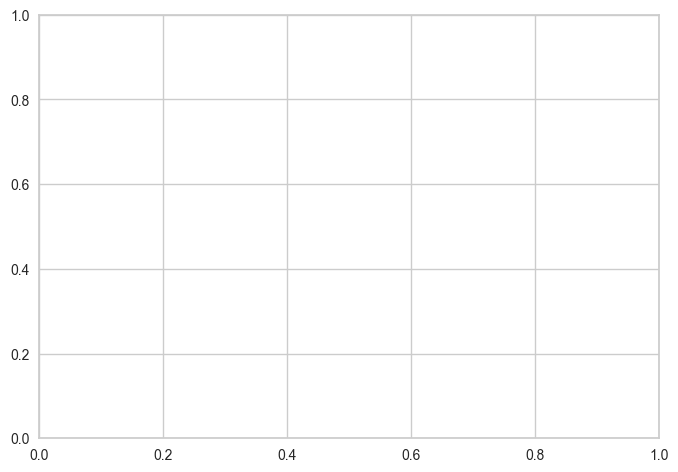

In [77]:
evaluate_model(best_model)

In [ ]:
predictions = predict_model(best_model, data=data)
predictions.head()